=== Evaluación rápida (test) ===
              precision    recall  f1-score   support

    NEGATIVO       0.14      0.25      0.18         4
     NEUTRAL       0.00      0.00      0.00         4
    POSITIVO       0.20      0.25      0.22         4

    accuracy                           0.17        12
   macro avg       0.11      0.17      0.13        12
weighted avg       0.11      0.17      0.13        12



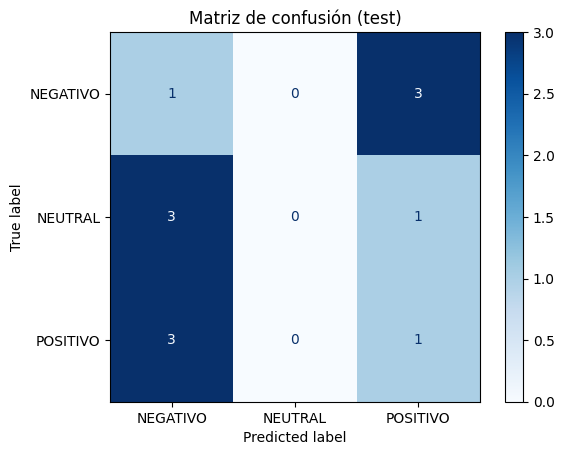


=== 1) TEXTO DE ENTRADA ===
Ver y jugar futbol me hace feliz

=== 2) PREPROCESAMIENTO (limpieza/normalización) ===
jugar futbol feliz

=== 3) ANÁLISIS LINGÜÍSTICO (tokens/lemmas/POS/NER) ===
Tokens: ['Ver', 'y', 'jugar', 'futbol', 'me', 'hace', 'feliz']
Lemas: ['Ver', 'y', 'jugar', 'futbol', 'yo', 'hacer', 'feliz']
POS (palabra, etiqueta): [('Ver', 'PROPN'), ('y', 'CCONJ'), ('jugar', 'VERB'), ('futbol', 'NOUN'), ('me', 'PRON'), ('hace', 'VERB'), ('feliz', 'ADJ')]
Entidades NER (texto, tipo): —

=== 4) REPRESENTACIÓN NUMÉRICA (Top TF-IDF) ===
[('feliz', 1.0)]

=== 5) MODELO (Naive Bayes) ===
Probabilidades -> NEG: 0.28 | NEU: 0.28 | POS: 0.44

=== 6) SALIDA FINAL ===
➡ Resultado: POSITIVO 😀



In [ ]:
# ==========================================================
# Sentimiento ES (negativo / neutral / positivo)
# spaCy (lemmas) + TF-IDF + Naive Bayes
# Múltiples modos de entrada: 'colab_form' | 'widgets' | 'input'
# Pipeline explicado paso a paso (como la infografía)
# ==========================================================

# === 0) Modo de entrada (cámbialo si quieres) ===
# Si estás en Google Colab, 'colab_form' es lo más robusto.
# En Jupyter con ipywidgets instalados, usa 'widgets'.
# En terminal/Jupyter sin widgets, usa 'input'.
try:
    import google.colab  # detecta Colab
    MODO_ENTRADA = "colab_form"
except Exception:
    MODO_ENTRADA = "widgets"  # cámbialo a "input" si no ves los widgets

import warnings, numpy as np
warnings.filterwarnings("ignore")
from pprint import pprint

# === 1) spaCy: cargar/descargar modelo ES ===
try:
    import spacy
    nlp = spacy.load("es_core_news_sm")
except Exception:
    import spacy, spacy.cli
    print("Descargando modelo 'es_core_news_sm' (solo la 1ª vez)...")
    spacy.cli.download("es_core_news_sm")
    nlp = spacy.load("es_core_news_sm")

# === 2) Dataset demo (puedes ampliarlo/ajustarlo) ===
positivos = [
    "Me encanta este servicio","El soporte fue excelente","Estoy muy satisfecho",
    "La experiencia fue maravillosa","Muy contento con la compra","El curso estuvo genial",
    "Buena calidad y buen precio","Me gusta aprender cada día","Estoy progresando y eso me alegra",
    "El producto superó mis expectativas","Aprender me hace feliz","Estoy aprendiendo mucho",
    "Fue una atención impecable","Todo salió mejor de lo esperado",
    "La entrega fue rápida y sin problemas"
]
negativos = [
    "Odio este producto","La atención es pésima","Me siento frustrado con el resultado",
    "El envío llegó tarde y mal","Nunca volveré a comprar aquí","El curso fue un desastre",
    "La calidad es terrible","Estoy muy molesto con el servicio","Fue una pérdida de tiempo",
    "No recomendaría esto a nadie","La experiencia fue horrible","Estoy decepcionado",
    "Tuve muchos problemas con la compra","El soporte no respondió","Muy mala calidad para el precio"
]
neutrales = [
    "Hoy es lunes","Tengo que ir al trabajo","El paquete llegó","Estoy estudiando para el examen",
    "El clima está nublado","La reunión es a las 3","Necesito más información",
    "Estoy aprendiendo mucho sobre redes","Voy a revisar los documentos","Mañana es feriado",
    "El sistema se actualizó","Compré un libro ayer","Estoy leyendo el manual",
    "El pedido está en camino","Tenemos clase de NLP hoy"
]
textos  = positivos + negativos + neutrales
labels  = ([2]*len(positivos)) + ([0]*len(negativos)) + ([1]*len(neutrales))  # 0=NEG, 1=NEU, 2=POS
id2label = {0:"NEGATIVO 😡", 1:"NEUTRAL 😐", 2:"POSITIVO 😀"}

# === 3) Preprocesamiento con spaCy ===
def limpiar_texto(texto: str) -> str:
    """Minúsculas + lemas; filtra stopwords/puntuación/URLs/emails."""
    doc = nlp(texto.lower())
    keep = []
    for t in doc:
        if t.is_space or t.is_punct or t.like_url or t.like_email:
            continue
        if t.is_stop:
            continue
        keep.append(t.lemma_)
    return " ".join(keep)

def analizar_linguistico(texto: str):
    """Tokens, lemas, POS y entidades NER para mostrar paso a paso."""
    doc = nlp(texto)
    tokens = [t.text for t in doc if not t.is_space]
    lemmas = [t.lemma_ for t in doc if not t.is_space]
    pos = [(t.text, t.pos_) for t in doc if not t.is_space]
    ents = [(ent.text, ent.label_) for ent in doc.ents]
    return tokens, lemmas, pos, ents

# === 4) Pipeline TF-IDF + Naive Bayes ===
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        preprocessor=limpiar_texto,
        ngram_range=(1,2),   # unigrams + bigrams
        min_df=1,
        max_df=0.95
    )),
    ("nb", MultinomialNB())
])

# === 5) Entrenar + evaluación rápida (transparencia) ===
X_train, X_test, y_train, y_test = train_test_split(
    textos, labels, test_size=0.25, random_state=42, stratify=labels
)
pipe.fit(X_train, y_train)
print("=== Evaluación rápida (test) ===")
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["NEGATIVO","NEUTRAL","POSITIVO"]))
try:
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, display_labels=["NEGATIVO","NEUTRAL","POSITIVO"], cmap="Blues"
    )
    plt.title("Matriz de confusión (test)")
    plt.show()
except Exception:
    pass

# === 6) Utilidad: Top TF-IDF (qué rasgos usó el modelo para tu texto) ===
def top_tfidf(texto: str, pipe, k: int = 10):
    X = pipe.named_steps["tfidf"].transform([texto])
    feats = pipe.named_steps["tfidf"].get_feature_names_out()
    vec = X.toarray()[0]
    nz = vec.nonzero()[0]
    pares = [(feats[i], float(vec[i])) for i in nz]
    pares.sort(key=lambda x: x[1], reverse=True)
    return pares[:k]

# === 7) Paso a paso (como tu diagrama) ===
def analizar_texto_paso_a_paso(texto: str):
    print("\n=== 1) TEXTO DE ENTRADA ===")
    print(texto)

    print("\n=== 2) PREPROCESAMIENTO (limpieza/normalización) ===")
    limpio = limpiar_texto(texto)
    print(limpio if limpio else "(quedó vacío tras filtrar)")

    print("\n=== 3) ANÁLISIS LINGÜÍSTICO (tokens/lemmas/POS/NER) ===")
    tokens, lemmas, pos, ents = analizar_linguistico(texto)
    print("Tokens:", tokens)
    print("Lemas:", lemmas)
    print("POS (palabra, etiqueta):", pos)
    print("Entidades NER (texto, tipo):", ents if ents else "—")

    print("\n=== 4) REPRESENTACIÓN NUMÉRICA (Top TF-IDF) ===")
    print(top_tfidf(texto, pipe, k=10) or "—")

    print("\n=== 5) MODELO (Naive Bayes) ===")
    proba = pipe.predict_proba([texto])[0]     # [neg, neu, pos]
    pred  = int(pipe.predict([texto])[0])
    print(f"Probabilidades -> NEG: {proba[0]:.2f} | NEU: {proba[1]:.2f} | POS: {proba[2]:.2f}")

    print("\n=== 6) SALIDA FINAL ===")
    print(f"➡ Resultado: {id2label[pred]}\n")

# === 8) MODO: 'colab_form' | 'widgets' | 'input' ===

if MODO_ENTRADA == "colab_form":
    # ----- Google Colab FORM -----
    # Cambia el texto en el campo y vuelve a ejecutar la celda.
    #@title Analizar un texto (Colab Form)
    texto_usuario = "Ver y jugar futbol me hace feliz"  #@param {type:"string"}
    ejecutar = True  #@param {type:"boolean"}

    if ejecutar and texto_usuario.strip():
        analizar_texto_paso_a_paso(texto_usuario)
    else:
        print("Escribe un texto en el formulario y activa 'ejecutar'.")

elif MODO_ENTRADA == "widgets":
    # ----- Jupyter con ipywidgets -----
    try:
        # En Colab, habilita el gestor de widgets
        try:
            from google.colab import output
            output.enable_custom_widget_manager()
        except Exception:
            pass

        import ipywidgets as widgets
        from IPython.display import display, clear_output

        caja = widgets.Text(
            placeholder="Escribe aquí el texto a analizar...",
            description="Texto:",
            layout=widgets.Layout(width="90%")
        )
        btn = widgets.Button(description="Analizar", button_style="primary")
        out = widgets.Output()

        def on_click(_):
            with out:
                clear_output(wait=True)
                t = caja.value.strip()
                if not t:
                    print("Por favor, escribe un texto.")
                else:
                    analizar_texto_paso_a_paso(t)

        display(caja, btn, out)
        btn.on_click(on_click)
        print("Modo widgets listo: escribe en la caja y pulsa 'Analizar'.")
    except Exception as e:
        print("No se pudieron cargar los widgets. Cambia MODO_ENTRADA a 'input'.")
        print("Detalle:", e)

else:
    # ----- Consola/Jupyter clásico con input() -----
    print("\nEscribe un texto para analizar (o SALIR para terminar).")
    while True:
        try:
            t = input("\n[TEXTO] ").strip()
        except EOFError:
            print("\nEntrada interrumpida. Fin.")
            break
        if not t:
            print("⚠ Texto vacío. Intenta nuevamente.")
            continue
        if t.lower() == "salir":
            print("✅ Fin del análisis. ¡Gracias!")
            break
        analizar_texto_paso_a_paso(t)
